In [49]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
%autoreload 2

import torch
from lovely_tensors import monkey_patch; monkey_patch()
from transformers import GPT2Tokenizer


In [355]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

token_ids = tokenizer.encode(
    "The capital of France is Paris. The capital of England is",
    return_tensors="pt",
)


token_ids

tensor[1, 12] i64 x∈[13, 6342] μ=2.005e+03 σ=2.265e+03

In [350]:

# state_log

In [65]:
import pickle

model_state = dict(torch.load("pytorch_model.bin"))
# model_state

In [315]:
model_state

{'wte.weight': tensor[50257, 768] n=38597376 (0.1Gb) x∈[-1.270, 1.785] μ=0.000 σ=0.144,
 'wpe.weight': tensor[1024, 768] n=786432 (3Mb) x∈[-4.538, 4.065] μ=-0.001 σ=0.123,
 'h.0.ln_1.weight': tensor[768] 3Kb x∈[0.042, 0.253] μ=0.180 σ=0.041,
 'h.0.ln_1.bias': tensor[768] 3Kb x∈[-0.259, 0.202] μ=-0.007 σ=0.036,
 'h.0.attn.bias': tensor[1, 1, 1024, 1024] n=1048576 (4Mb) x∈[0., 1.000] μ=0.500 σ=0.500,
 'h.0.attn.c_attn.weight': tensor[768, 2304] n=1769472 (6.8Mb) x∈[-2.844, 2.796] μ=5.338e-05 σ=0.200,
 'h.0.attn.c_attn.bias': tensor[2304] 9Kb x∈[-1.337, 1.175] μ=-0.001 σ=0.226,
 'h.0.attn.c_proj.weight': tensor[768, 768] n=589824 (2.2Mb) x∈[-3.317, 3.061] μ=-0.000 σ=0.147,
 'h.0.attn.c_proj.bias': tensor[768] 3Kb x∈[-2.684, 2.030] μ=-0.007 σ=0.259,
 'h.0.ln_2.weight': tensor[768] 3Kb x∈[0.045, 1.511] μ=0.868 σ=0.485,
 'h.0.ln_2.bias': tensor[768] 3Kb x∈[-0.665, 0.739] μ=0.009 σ=0.070,
 'h.0.mlp.c_fc.weight': tensor[768, 3072] n=2359296 (9Mb) x∈[-2.313, 4.588] μ=-0.001 σ=0.141,
 'h.0.mlp.c

In [111]:
w_q, w_k, w_v = model_state["h.0.attn.c_attn.weight"].chunk(3, dim=1)
b_q, b_k, b_v = model_state["h.0.attn.c_attn.bias"].chunk(3, dim=0)

k = b_k + state_log["layers"][0]["ln_1"] @ w_k
k

tensor[1, 6, 768] n=4608 (18Kb) x∈[-6.708, 7.761] μ=0.039 σ=1.364

In [106]:
state_log["layers"][0]["attention_log"]["key"]

tensor[1, 6, 768] n=4608 (18Kb) x∈[-6.708, 7.761] μ=0.039 σ=1.364

In [113]:
torch.allclose(k, state_log["layers"][0]["attention_log"]["key"], atol=1e-5)

True

In [103]:
k.chans(scale=4)

In [104]:
state_log["layers"][0]["attention_log"]["key"].chans(scale=4)

In [109]:
(k - state_log["layers"][0]["attention_log"]["key"])

tensor[1, 6, 768] n=4608 (18Kb) x∈[-2.861e-06, 3.576e-06] μ=3.154e-10 σ=2.318e-07

In [ ]:
torch.nn.Conv1d(
    in_channels=768, out_channels=768 * 3, kernel_size=1, bias=True
).state_dict()

In [80]:
model_state["h.0.attn.c_attn.weight"]

tensor[768, 2304] n=1769472 (6.8Mb) x∈[-2.844, 2.796] μ=5.338e-05 σ=0.200

In [81]:
torch.nn.Linear(in_features=768, out_features=768 * 3, bias=True).state_dict()

OrderedDict([('weight',
              tensor[2304, 768] n=1769472 (6.8Mb) x∈[-0.036, 0.036] μ=6.789e-06 σ=0.021),
             ('bias', tensor[2304] 9Kb x∈[-0.036, 0.036] μ=-0.000 σ=0.021)])

In [126]:
from IPython.display import display

In [128]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [356]:
import math

from transformers import GPT2Model
from transformers.models.gpt2.modeling_gpt2 import state_log

model = GPT2Model.from_pretrained("gpt2")
_ = model.eval()
with torch.no_grad():
    outputs = model(token_ids, output_hidden_states=True)


def new_gelu(input):
    return (
        0.5
        * input
        * (
            1.0
            + torch.tanh(
                math.sqrt(2.0 / math.pi) * (input + 0.044715 * torch.pow(input, 3.0))
            )
        )
    )

def conv_1d(x, weight, bias=None):
    size_out = x.size()[:-1] + (weight.size(-1),)
    x = torch.addmm(bias, x.view(-1, x.size(-1)), weight)
    x = x.view(size_out)
    return x


attention_masked = None

def transformer_block(i, input_hidden_state, model_state, state_log):
    global attention_masked
    print("input_hidden_state=",input_hidden_state )
    def block_state(key):
        return model_state[f"h.{i}.{key}"]

    def attention_state(key):
        return model_state[f"h.{i}.attn.{key}"]

    # attention block
    ln1 = torch.nn.functional.layer_norm(
        input=input_hidden_state,
        weight=block_state("ln_1.weight"),
        bias=block_state("ln_1.bias"),
        normalized_shape=(768,),
    )

    print("ln1=",ln1 )
    assert torch.allclose(ln1, state_log["layers"][i]["ln_1"]), "Layer norm is wrong"

    w_q, w_k, w_v = attention_state("c_attn.weight").chunk(3, dim=1)
    b_q, b_k, b_v = attention_state("c_attn.bias").chunk(3, dim=0)

    # q = ln1 @ w_q + b_q
    # k = ln1 @ w_k + b_k
    # v = ln1 @ w_v + b_v

    q= conv_1d(ln1, w_q, b_q)
    k= conv_1d(ln1, w_k, b_k)
    v= conv_1d(ln1, w_v, b_v)


    print("Key=",k )
    assert torch.allclose(
        k, state_log["layers"][i]["attention_log"]["key"]
    ), "Key is wrong"

    print("Query=",q )
    assert torch.allclose(
        q, state_log["layers"][i]["attention_log"]["query"]
    ), "Query is wrong"


    print("Value=",v )
    assert torch.allclose(
        v, state_log["layers"][i]["attention_log"]["value"]
    ), "Value is wrong"

    assert torch.eq(q, state_log["layers"][i]["attention_log"]["query"]).all(), "Query is wrong"
    assert torch.eq(k, state_log["layers"][i]["attention_log"]["key"]).all(), "Key is wrong"
    assert torch.eq(v, state_log["layers"][i]["attention_log"]["value"]).all(), "Value is wrong"

    q_chunked = torch.stack(q.chunk(12, dim=-1))
    k_chunked = torch.stack(k.chunk(12, dim=-1))
    v_chunked = torch.stack(v.chunk(12, dim=-1))

    # attention = q_chunked @ k_chunked.transpose(-1, -2)
    attention = torch.matmul(q_chunked, k_chunked.transpose(-1, -2))

    attention_rescaled = attention / (64**0.5)


    mask = torch.triu(torch.ones_like(attention_rescaled), diagonal=1).bool()
    attention_masked = attention_rescaled.masked_fill(mask, torch.finfo(torch.float32).min) 

    assert torch.allclose(
        attention_masked, state_log["layers"][i]["attention_log"]["attention_masked"], atol=1e-5
    ), "Attention masked is wrong"



    # display(attention_masked.chans(scale=4, cmap="seismic"))

    attention_softmaxed = torch.nn.functional.softmax(attention_masked, dim=-1)

    # display(attention_rescaled.chans(scale=4, cmap="seismic"))
    # display(attention_softmaxed.chans(scale=4, cmap="seismic"))

    attention_output = torch.matmul(attention_softmaxed, v_chunked)
    # attention_output = attention_softmaxed @ v_chunked
    # display(attention_output.chans(scale=4, cmap="seismic"))

    print("attention_output=",attention_output )
   
    out_tuple = [x[0] for x in attention_output.chunk(12, dim=0)]


    print("out_tuple=",out_tuple )
    combined_attention_output = torch.cat(out_tuple, dim=-1)
    # display(combined_attention_output.chans(scale=4, cmap="seismic"))

    print("combined_attention_output=",combined_attention_output )

    w_cproj = attention_state("c_proj.weight")
    b_cproj = attention_state("c_proj.bias")

    # crosstalk = combined_attention_output @ w_cproj + b_cproj
    crosstalk = conv_1d(combined_attention_output, w_cproj, b_cproj)

    # crosstalk = torch.nn.functional.linear(weight=attention_state("c_proj.weight"), bias=attention_state("c_proj.bias"), input=combined_attention_output)
    # display(crosstalk.chans(scale=4, cmap="seismic"))

    after_residual = crosstalk + input_hidden_state

    print("after_residual=",after_residual )

    # mlp block
    before_ln2 = after_residual

    ln2 = torch.nn.functional.layer_norm(
        input=after_residual,
        weight=block_state("ln_2.weight"),
        bias=block_state("ln_2.bias"),
        normalized_shape=(768,),
    )

    w_fc = block_state("mlp.c_fc.weight")
    b_fc = block_state("mlp.c_fc.bias")

    # after_up = ln2 @ w_fc + b_fc
    after_up = conv_1d(ln2, w_fc, b_fc)


    activated = new_gelu(after_up)

    w_proj = block_state("mlp.c_proj.weight")
    b_proj = block_state("mlp.c_proj.bias")

    # after_down = activated @ w_proj + b_proj
    after_down = conv_1d(activated, w_proj, b_proj)

    after_residual_2 = after_down + before_ln2
    print("after_residual_2=",after_residual_2 )

    return after_residual_2


def our_model(token_ids, model_state, state_log):
    token_embeddings = model_state["wte.weight"][token_ids]
    positions = torch.arange(len(token_ids))  # [0,1,2,3...]
    position_embeddings = model_state["wpe.weight"][positions]
    embeddings = token_embeddings + position_embeddings

    if torch.allclose(embeddings, state_log["layers"][0]["input_hidden_states"]):
        print("Embeddings are correct")
    else:
        print("Embeddings are wrong")

    hs = embeddings
    for i in range(12):
        print(f"Running transformer block {i}")
        hs = transformer_block(i, hs, model_state, state_log)

    ln_w = model_state["ln_f.weight"]
    ln_b = model_state["ln_f.bias"]

    ln = torch.nn.functional.layer_norm(
        input=hs, weight=ln_w, bias=ln_b, normalized_shape=(768,)
    )

    return ln

out = our_model(token_ids[0], model_state, state_log)

# out[0].chans(scale=4, cmap="seismic")
# out[1].chans(scale=4, cmap="seismic")
# out[2].chans(scale=4, cmap="seismic")
# out[3]

Embeddings are correct
Running transformer block 0
input_hidden_state= tensor[12, 768] n=9216 (36Kb) x∈[-4.562, 3.703] μ=-0.003 σ=0.208
ln1= tensor[12, 768] n=9216 (36Kb) x∈[-0.809, 0.678] μ=-0.005 σ=0.100
Key= tensor[12, 768] n=9216 (36Kb) x∈[-6.061, 7.721] μ=0.037 σ=1.444
Query= tensor[12, 768] n=9216 (36Kb) x∈[-4.105, 4.369] μ=-0.055 σ=0.931
Value= tensor[12, 768] n=9216 (36Kb) x∈[-1.188, 3.213] μ=0.008 σ=0.237
attention_output= tensor[12, 12, 64] n=9216 (36Kb) x∈[-0.936, 1.915] μ=0.008 σ=0.158
out_tuple= [tensor[12, 64] n=768 (3Kb) x∈[-0.345, 0.800] μ=0.012 σ=0.105, tensor[12, 64] n=768 (3Kb) x∈[-0.694, 0.919] μ=0.018 σ=0.208, tensor[12, 64] n=768 (3Kb) x∈[-0.293, 1.330] μ=0.018 σ=0.155, tensor[12, 64] n=768 (3Kb) x∈[-0.903, 0.789] μ=0.016 σ=0.173, tensor[12, 64] n=768 (3Kb) x∈[-0.417, 0.583] μ=0.005 σ=0.122, tensor[12, 64] n=768 (3Kb) x∈[-0.662, 0.634] μ=-0.005 σ=0.165, tensor[12, 64] n=768 (3Kb) x∈[-0.377, 0.404] μ=0.006 σ=0.121, tensor[12, 64] n=768 (3Kb) x∈[-0.259, 0.678] μ=0.0

In [313]:
outputs.last_hidden_state - out

tensor[1, 10, 768] n=7680 (30Kb) all_zeros

In [337]:
out @ model_state["wte.weight"].T

tensor[6, 50257] n=301542 (1.2Mb) x∈[-302.044, -31.864] μ=-110.059 σ=69.994

In [360]:
softmaxed = torch.nn.functional.softmax(out @ model_state["wte.weight"].T, dim=-1)
softmaxed

tensor[12, 50257] n=603084 (2.3Mb) x∈[2.286e-20, 0.780] μ=1.990e-05 σ=0.002

In [362]:
top_5_indices = torch.topk(softmaxed[-1], 5, dim=-1).indices
tokenizer.batch_decode(top_5_indices)

[' London', ' Liverpool', ' Cambridge', ' Manchester', ' the']

/home/xl0/work/projects/lovely-numpy/lovely_numpy/utils/colormap.py:65: RuntimeWarning: overflow encountered in multiply
  lut_idxs = (vals * cmax).astype(np.int64)


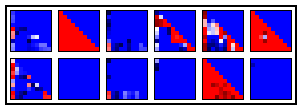

In [270]:
state_log["layers"][0]["attention_log"]["attention_masked"].chans(scale=4, cmap="seismic")

In [277]:
attention_masked

tensor[12, 1, 10, 10] n=1200 (4.7Kb) x∈[-3.403e+38, 5.849] μ=-inf σ=inf

In [278]:
state_log["layers"][1]["attention_log"]["attention_masked"]

tensor[1, 12, 10, 10] n=1200 (4.7Kb) x∈[-3.403e+38, 5.849] μ=-inf σ=inf

tensor[1, 10, 768] n=7680 (30Kb) all_zeros

In [229]:
- out[1]

tensor[1, 12, 10, 10] n=1200 (4.7Kb) x∈[-3.815e-06, 3.815e-06] μ=2.957e-08 σ=4.980e-07

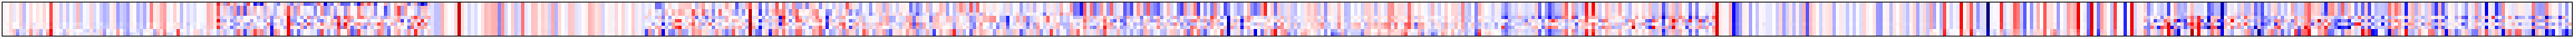

In [208]:
out_tuple = out.chunk(12, dim=0)

torch.cat(out_tuple, dim=-1).chans(scale=4, cmap="seismic")

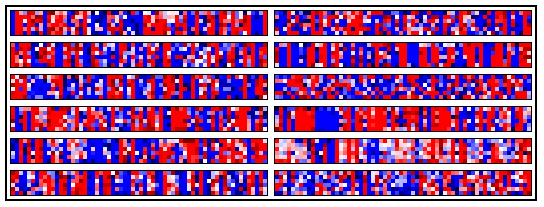

In [166]:
torch.stack(out[0].chunk(12, dim=2), dim=1).chans(scale=4, cmap="seismic")

1
2


In [167]:
token_ids

tensor[1, 6] i64 x∈[11, 15496] μ=5.585e+03 σ=7.129e+03 [[15496, 11, 616, 3290, 318, 13779]]

In [16]:
token_embeddings = model_state["wte.weight"][token_ids]
token_embeddings

tensor[1, 6, 768] n=4608 (18Kb) x∈[-0.668, 1.785] μ=4.578e-05 σ=0.115

In [17]:
positions = torch.arange(token_ids.shape[1])  # [0,1,2,3...]
position_embeddings = model_state["wpe.weight"][positions]
position_embeddings

tensor[6, 768] n=4608 (18Kb) x∈[-4.538, 4.065] μ=-0.003 σ=0.207

In [18]:
embeddings = token_embeddings + position_embeddings
embeddings

tensor[1, 6, 768] n=4608 (18Kb) x∈[-4.443, 3.683] μ=-0.003 σ=0.236

In [32]:
assert torch.allclose(embeddings, outputs["hidden_states"][0])